# Trabajo Final 
## Mineria de Texto

Integrantes:

- Freddy Abad L.
- Edisson Reinozo T.

### Tema

Análisis de categorías de noticias digitales para determinar tópicos cubiertos entre 2011-2015, mediante los algoritmos de clustering de KMeans, Spectrlj y Jerárquico,  en un dataset de tweets con temática de salud.

### Dataset a usar
Health News in Twitter Data Set 

### Link dataset
http://archive.ics.uci.edu/ml/datasets/Health+News+in+Twitter  


### Indicaciones

Este informe se realizo en Google Colab, los procesos de clustering **SON REALMENTE COSTOSOS TEMPORAL Y ESPACIALMENTE**, por lo cual, las graficas resultantes pueden no visualizarse correctamente de manera local. Se recomienda su lectura en este, atravez del siguiente link: https://colab.research.google.com/drive/1A_wHMcQWRns-Qt97k8qHofgLBv8QPWZe?usp=sharing

### Objetivo General
Obtener un entendimiento de los tópicos que cubren los medios de comunicación en el área salud y determinar si existe una variación de estos en el tiempo, mediante la aplicación de algoritmos no supervisados de clusterización.

# Metodología

## Preprocesamiento de datos

* Preprocesamiento de datos, eliminación de links y data innecesaria, eliminación de stopwords, análisis con solo stemming, solo lematización, stemming - lematización, eliminar palabras que no pertenecen al dominio ejemplo: RT - retweet.

In [ ]:
import pandas as pd
import csv

data = pd.read_csv("all_tweets_processing.csv", sep="|", quoting=csv.QUOTE_NONE, error_bad_lines=False) 
data[:5]

tweet id  ...          source
0  304596701757464576  ...  everydayhealth
1  304595191329853441  ...  everydayhealth
2  304587659018371072  ...  everydayhealth
3  304580073380524032  ...  everydayhealth
4  304572560270573569  ...  everydayhealth

[5 rows x 4 columns]

In [ ]:
# Eliminar links
import re
def clean_urls(tweet):
    return re.sub(r"http\S+", "", tweet, flags=re.MULTILINE)

def clean_useless_words(tweet):
    tweet = re.sub(r"RT", "", tweet, flags=re.MULTILINE)
    tweet = re.sub(r"&amp;", "", tweet, flags=re.MULTILINE)
    # Remove non word characters o @ o #
    tweet =  re.sub(r'[^\w\s\@\#]','',tweet)
    return tweet.strip()

data['tweet'] = data['tweet'].apply(clean_urls) 
data['tweet'] = data['tweet'].apply(clean_useless_words) 

In [ ]:
# Remove stopwords
import nltk
from nltk.corpus import stopwords  
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english')) 

def remove_stopwords(tweet):
    filtered_tweet = [w for w in tweet.split() if not w in stop_words]  
    return  ' '.join(filtered_tweet)

data['tweet'] = data['tweet'].apply(remove_stopwords) 
data['tweet'].tolist()[:5]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['#FastFood Makes Up 11 Percent #Calories US #Diet',
 '10 snacks help lose weight burn fat build muscle',
 '10 foods boost skin AND slim waistline',
 'What heart attack feels like women different men #GoRed',
 '#McDonalds oatmeal almost 7 teaspoons sugar More healthy fast food isnt']

In [ ]:
data_stemmed = data.copy()
data_lemmatized = data.copy()
data_stemmed_lemmatized = data.copy()

In [ ]:
# Stemming
from nltk.stem.porter import PorterStemmer
porter_stemmer = PorterStemmer()

def stemm_text(text):
    return ' '.join([porter_stemmer.stem(w) for w in text.split()])

In [ ]:
# lemmatization
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w) for w in text.split()])

In [ ]:
data_stemmed['tweet'] = data_stemmed['tweet'].apply(stemm_text)
data_lemmatized['tweet'] = data_lemmatized['tweet'].apply(lemmatize_text)

data_stemmed_lemmatized['tweet'] = data_stemmed_lemmatized['tweet'].apply(lemmatize_text)
data_stemmed_lemmatized['tweet'] = data_stemmed_lemmatized['tweet'].apply(stemm_text)

## Análisis descriptivo y estadístico

* Análisis descriptivo y estadístico de los datos para conocer más del dataset, por ejemplo: palabras más repetidas globalmente, jerarquía de palabras por mes y año, entre otros.

### Tweets en el tiempo

In [ ]:
# Exploración del texto
import datetime

def count_tweets_per_day(data):
    tweets_per_day = {}
    
    for index, row in data.iterrows():
        
        tweet_date = row['date and time']
        datetime_date =  datetime.datetime.strptime(tweet_date,'%a %b %d %H:%M:%S %z %Y').date()
        if tweets_per_day.get(datetime_date,False):
            tweets_per_day[datetime_date] += 1
        else:
            tweets_per_day[datetime_date] = 1
    return tweets_per_day

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

def plot_tweets_count_in_time(tweets_per_day, plot_title=''):
    tweets_per_day_list = list(tweets_per_day.items())
    tweets_per_day_list.sort(key=lambda item: item[0])

    plt.rcParams["figure.figsize"] = (23,10)
    dates = [timestamp for (timestamp, count) in tweets_per_day_list]
    count = [count for (timestamp, count) in tweets_per_day_list]

    plt.plot(dates, count,'--go')
    
    if plot_title:
        plt.title(plot_title)
    else:
        plt.title('Number of tweets Vs Date')
    plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
    plt.gcf().autofmt_xdate()
    plt.xlabel('Date')
    plt.ylabel('Tweet Count')
    plt.show()

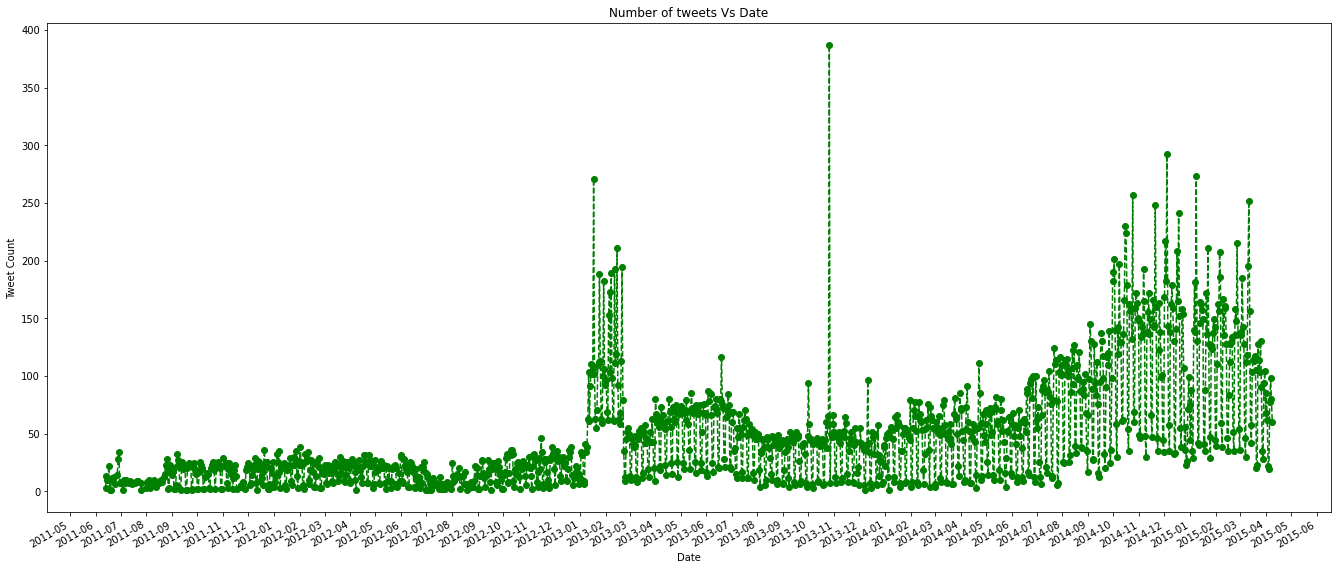

In [ ]:
tweets_per_day = count_tweets_per_day(data)
plot_tweets_count_in_time(tweets_per_day)

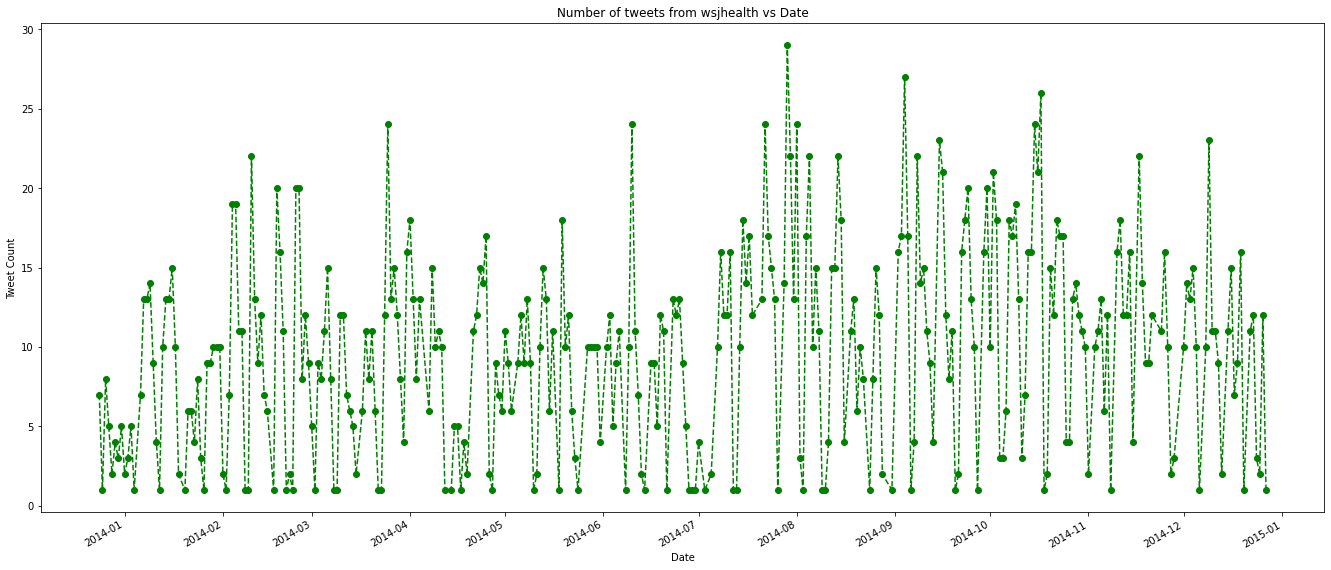

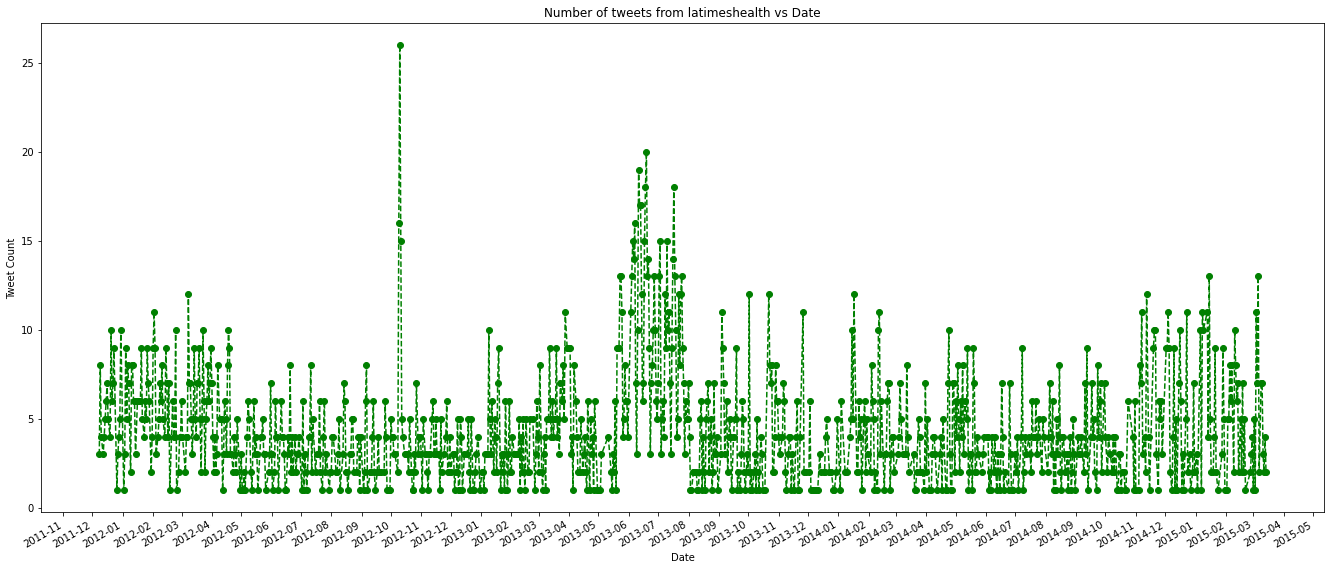

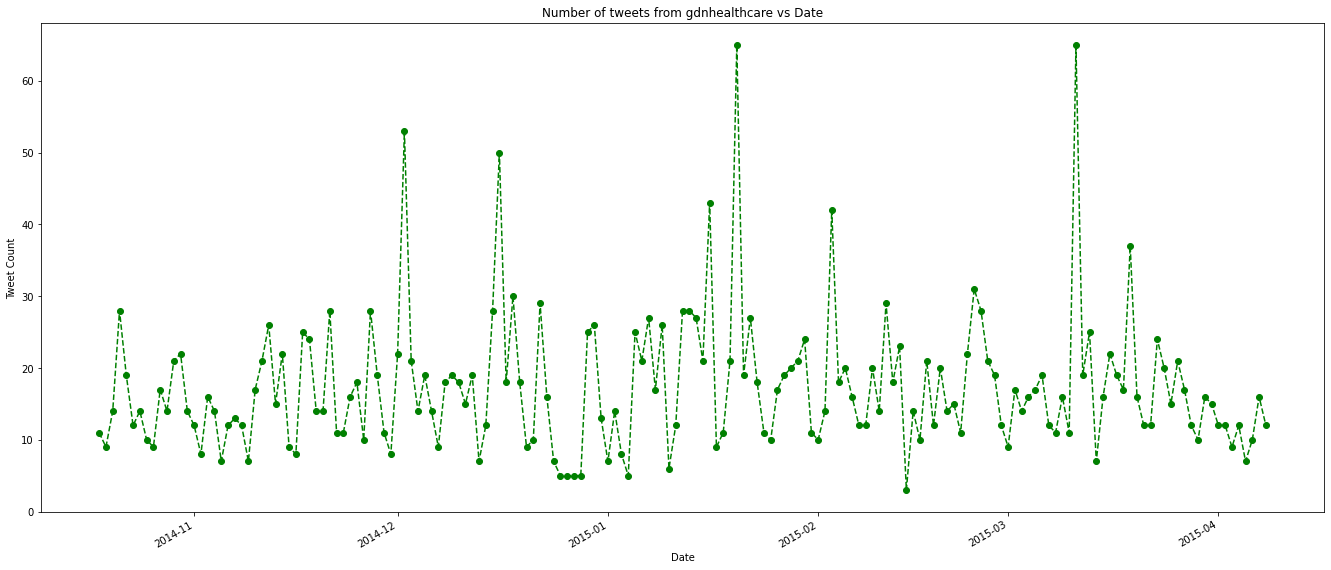

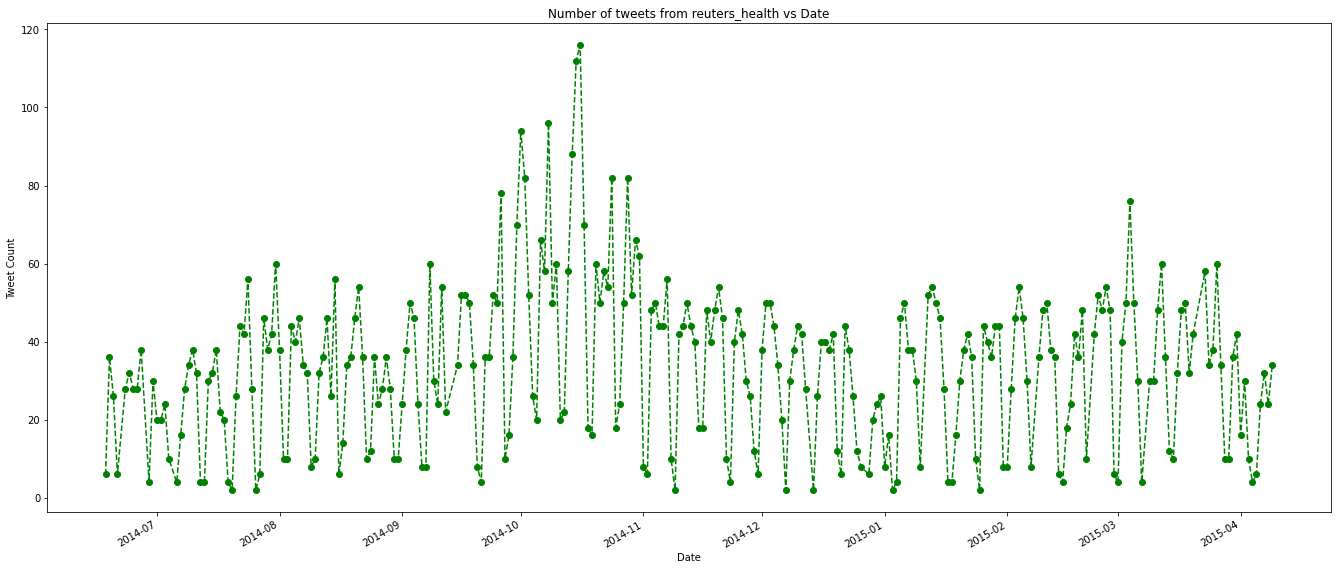

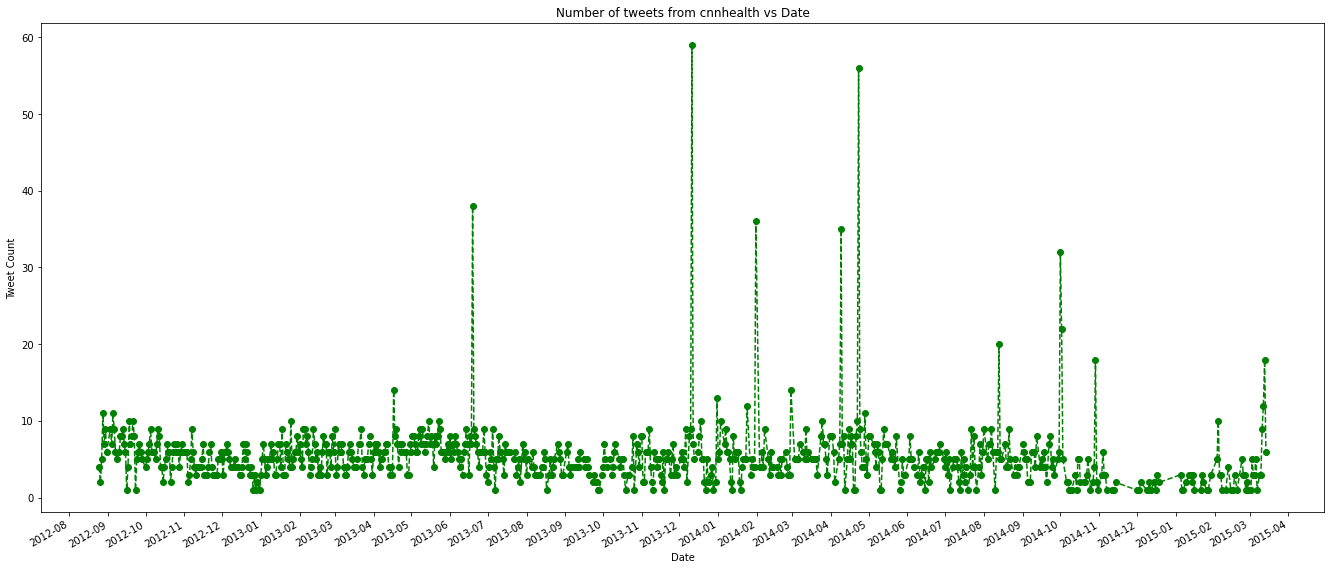

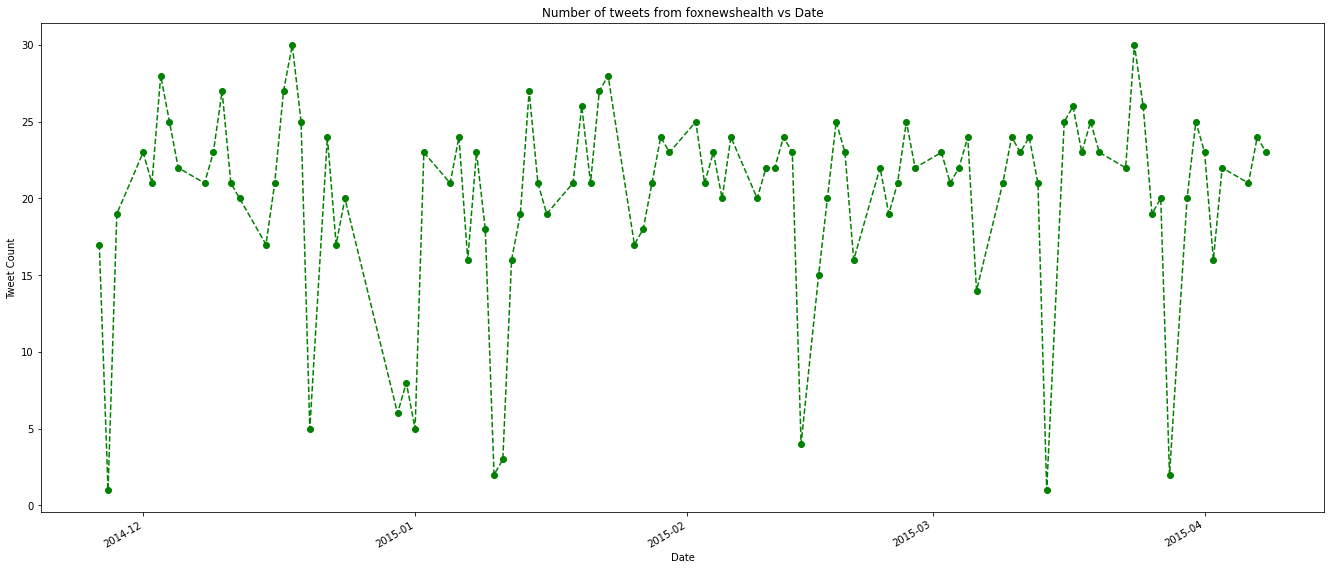

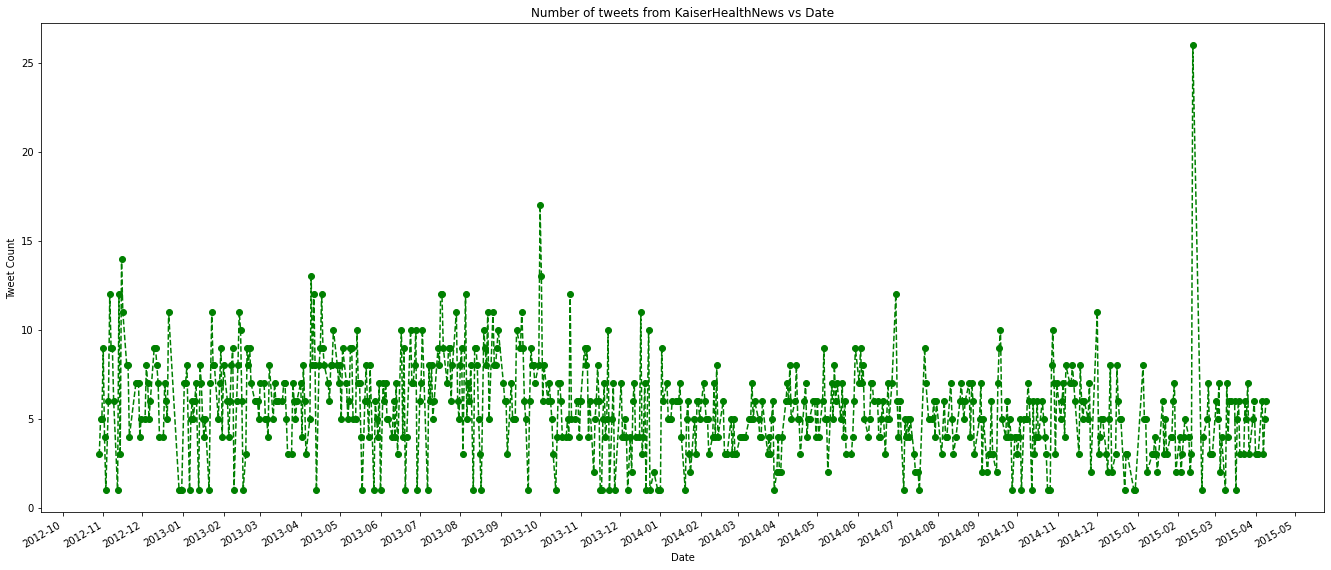

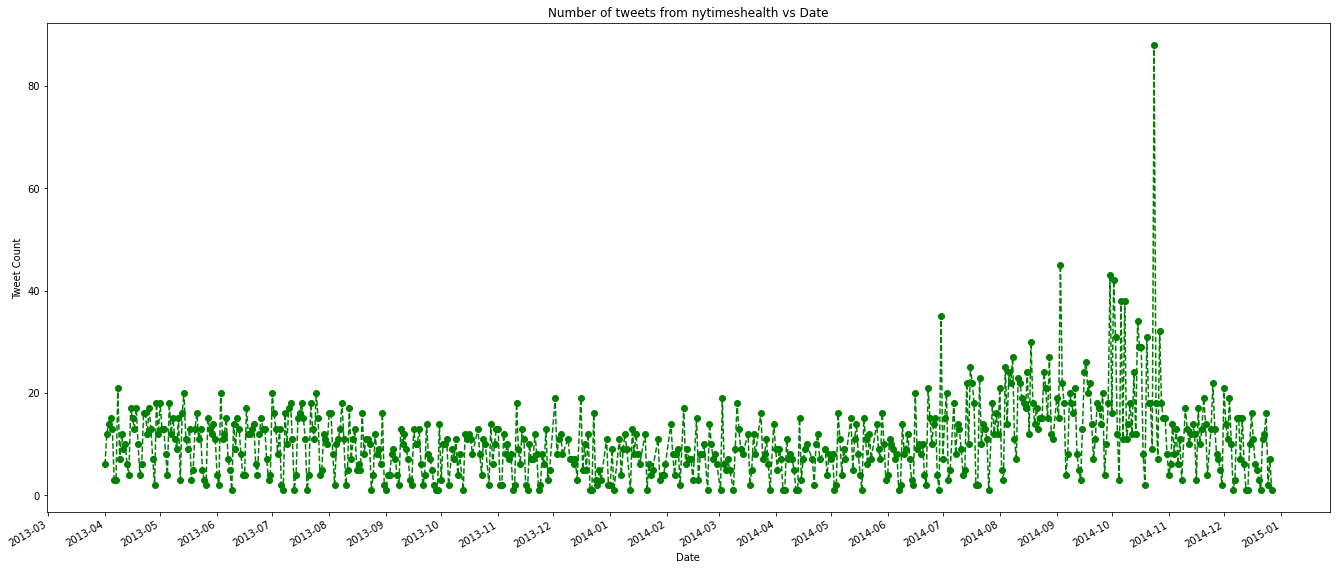

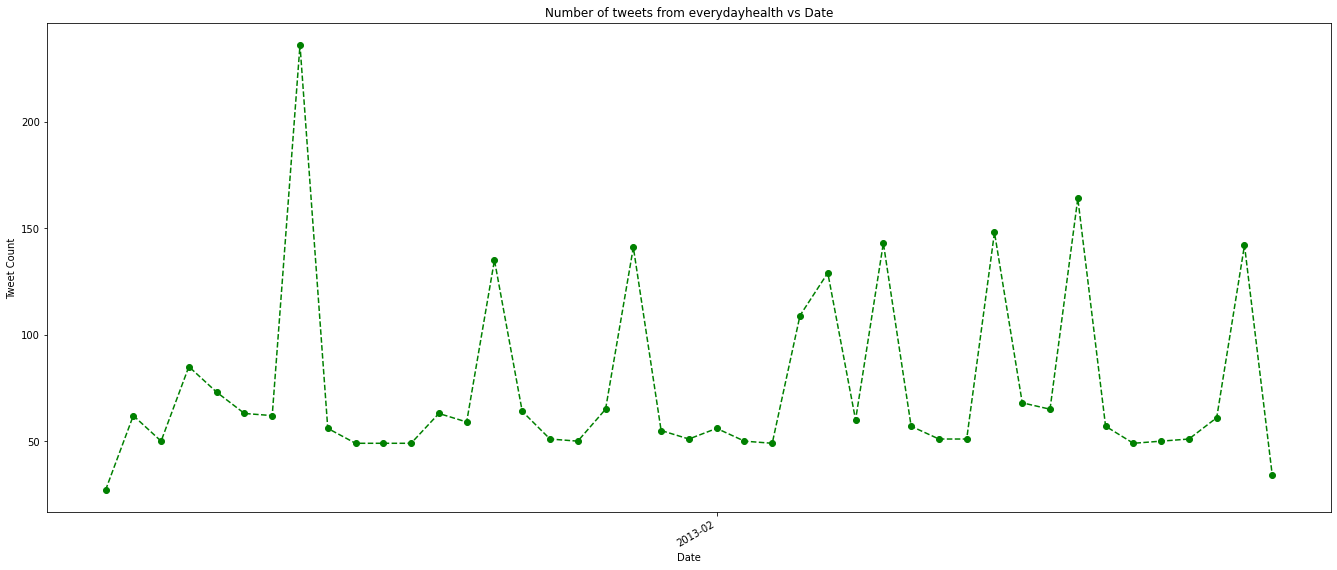

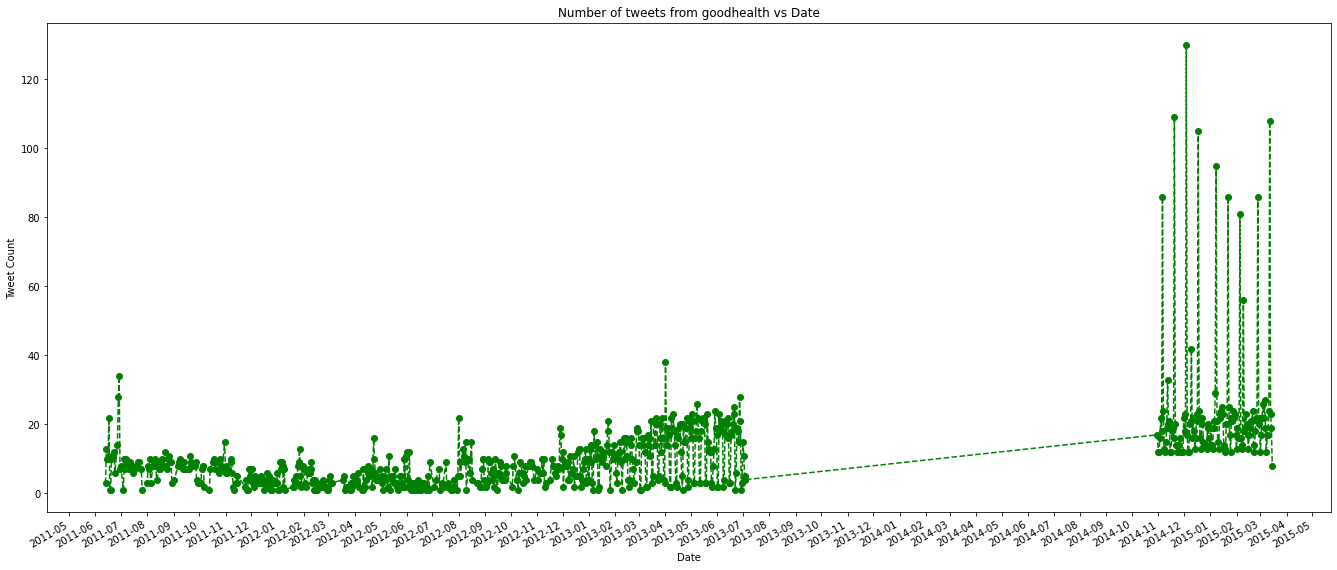

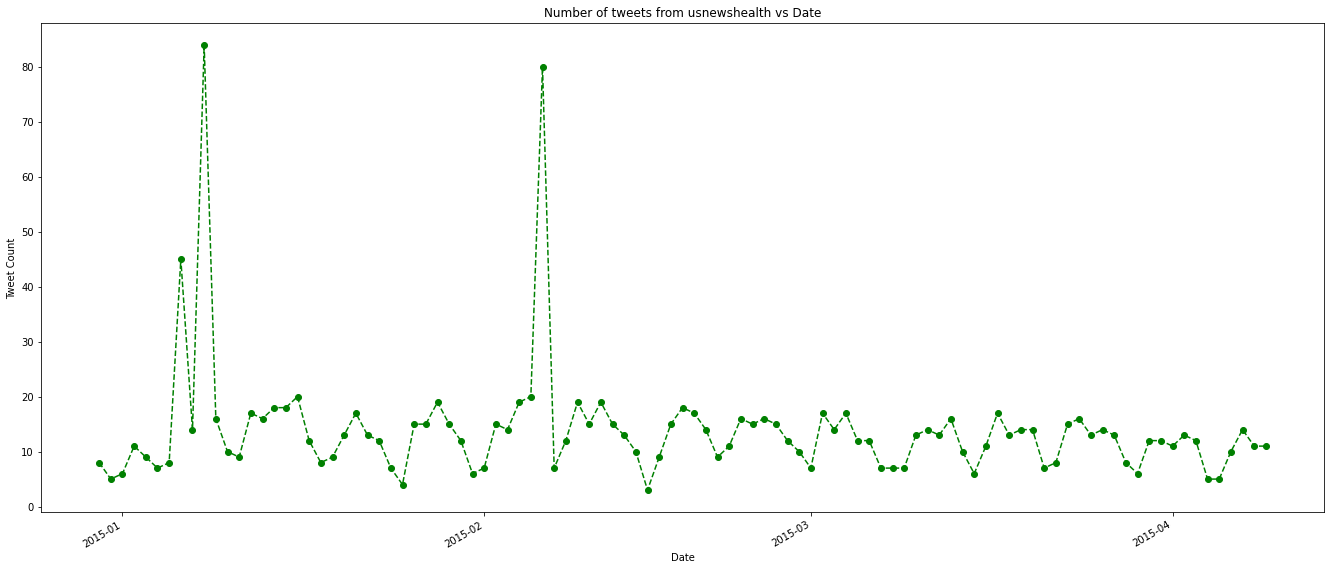

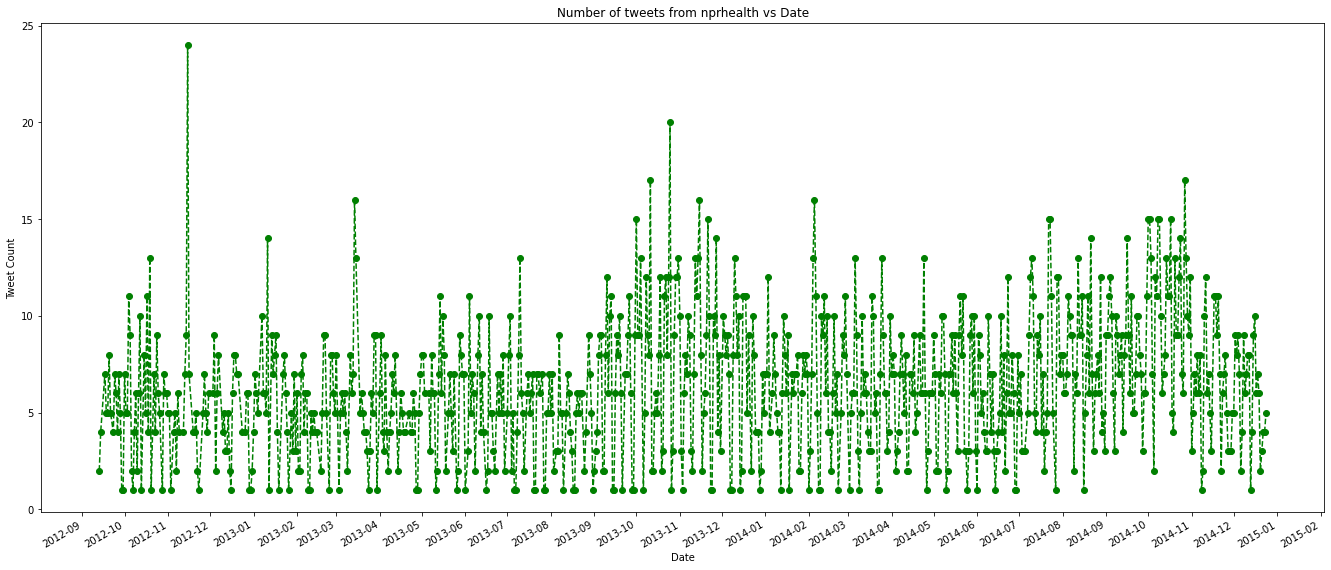

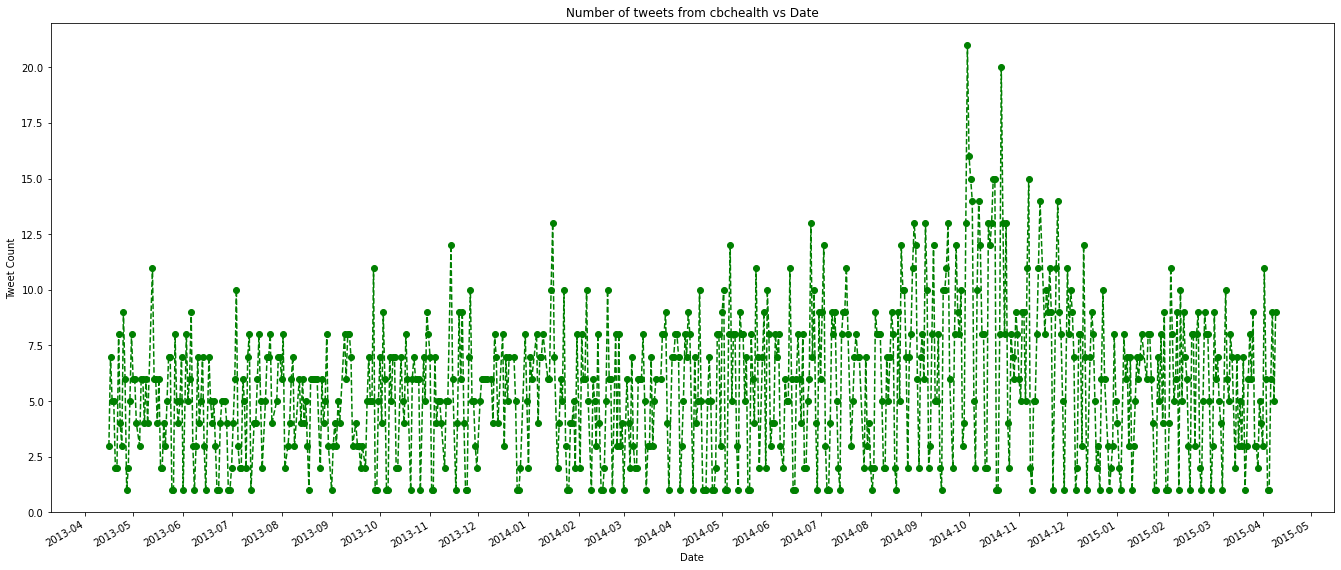

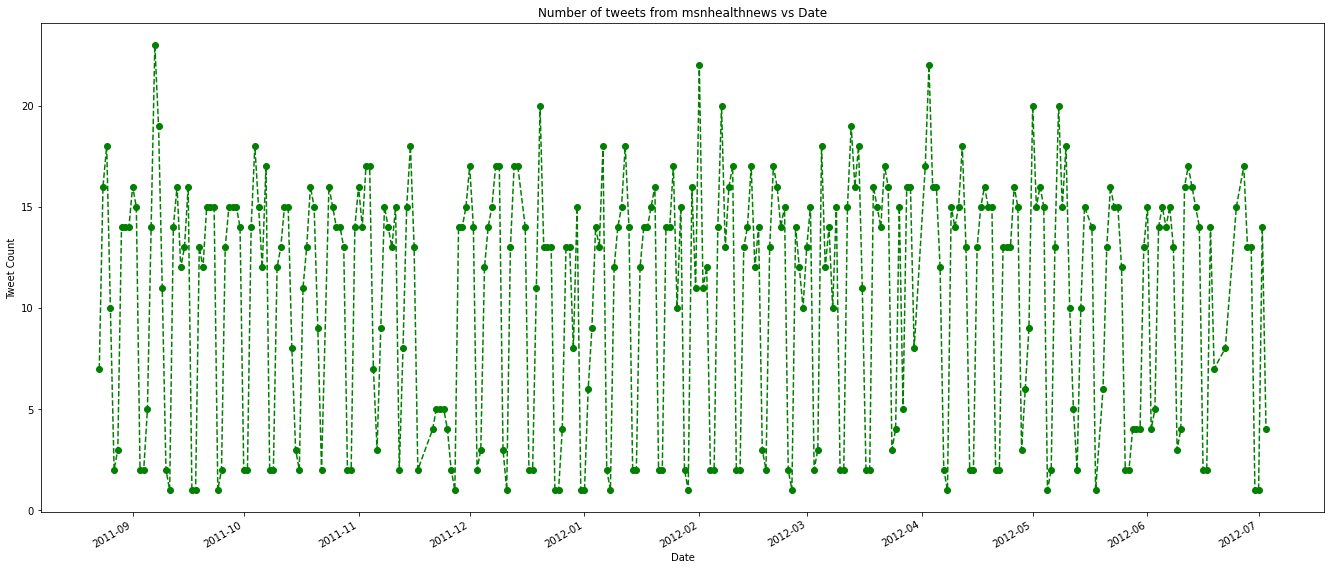

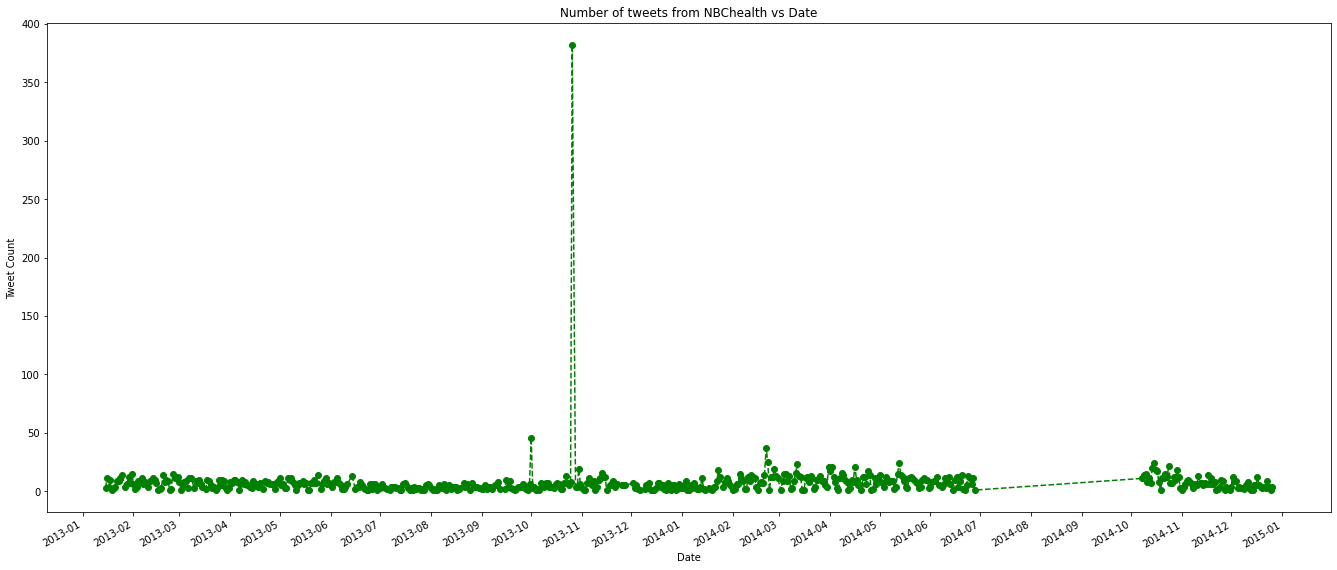

In [ ]:
media_sources = list(set(data['source'].tolist()))

for source in media_sources:
    is_source_data = data['source']== source
    
    tweets_per_day = count_tweets_per_day(data[is_source_data])
    plot_tweets_count_in_time(tweets_per_day, plot_title=f'Number of tweets from {source} vs Date')

### Palabras más representativas en tweets

In [ ]:
from nltk import ngrams, FreqDist

all_words_str = ' '.join(data['tweet'].tolist())
all_words = all_words_str.lower().split(' ')
all_words = [i for i in all_words if i]
all_counts = dict()

for size in range(1, 6):
    all_counts[size] = FreqDist(ngrams(all_words, size))

In [ ]:
word_count_1 = [(' '.join(k), v) for k,v in all_counts[4].items()]
word_count_1.sort(key=lambda item: item[1], reverse=True)
word_count_1[:10]

[('the new old age', 231),
 ('new old age blog', 222),
 ('@pharmalot pharmalot pharmalittle good', 91),
 ('pharmalot pharmalittle good morning', 91),
 ('a kidney 10000 paying', 50),
 ('kidney 10000 paying donors', 50),
 ('10000 paying donors actually', 50),
 ('paying donors actually pays', 50),
 ('donors actually pays new', 50),
 ('actually pays new study', 50)]

# Exploración del Dataset mediante Wordcloud

In [ ]:
from wordcloud import WordCloud

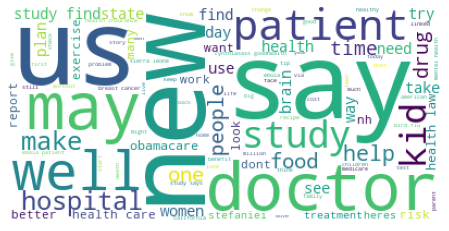

In [ ]:
wordcloud = WordCloud(max_words=100, background_color="white").generate(all_words_str.lower())

plt.rcParams["figure.figsize"] = (8,4)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Representar los tweets en TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer_stemmed = TfidfVectorizer(stop_words={'english'})
vectorizer_lemmatized = TfidfVectorizer(stop_words={'english'})
vectorizer_stemmed_lemmatized = TfidfVectorizer(stop_words={'english'})

tweets_stemmed = data_stemmed['tweet'].tolist()
tweets_lemmatized = data_lemmatized['tweet'].tolist()
tweets_stemmed_lemmatized = data_stemmed_lemmatized['tweet'].tolist()

X_stemmed = vectorizer_stemmed.fit_transform(tweets_stemmed)
X_lemmatized = vectorizer_lemmatized.fit_transform(tweets_lemmatized)
X_stemmed_lemmatized = vectorizer_stemmed_lemmatized.fit_transform(tweets_stemmed_lemmatized)

## Clustering

In [ ]:
from sklearn.cluster import KMeans
import seaborn as sns

def find_best_k_kmeans(data, K, title):
  inertias = []
  k_candidates = range(2, K)
  for k in k_candidates:
    k_means = KMeans(random_state=42, n_clusters=k)
    k_means.fit(data)
    inertias.append(k_means.inertia_)

  fig, ax = plt.subplots(figsize=(10, 6))
  sns.scatterplot(x=k_candidates, y = inertias, s=80, ax=ax)
  sns.lineplot(x=k_candidates, y = inertias, alpha=0.5, ax=ax)
  
  ax.set(title=title, ylabel='inertia', xlabel='k');

  return inertias

CPU times: user 18min 14s, sys: 4min 27s, total: 22min 42s
Wall time: 17min 53s


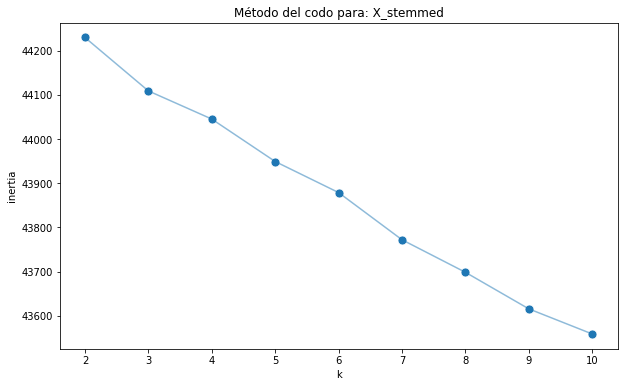

In [ ]:
%%time
inertias_X_stemmed = find_best_k_kmeans(X_stemmed, 11, "Método del codo para: X_stemmed")

CPU times: user 16min 57s, sys: 4min 2s, total: 20min 59s
Wall time: 16min 37s


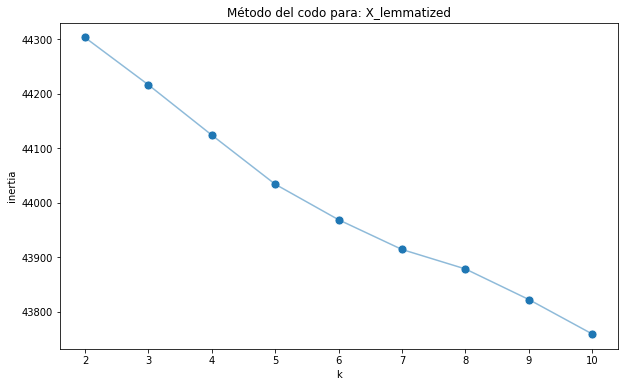

In [ ]:
%%time
inertias_X_lemmatized = find_best_k_kmeans(X_lemmatized, 11, "Método del codo para: X_lemmatized")

CPU times: user 24min 21s, sys: 5min 50s, total: 30min 12s
Wall time: 23min 54s


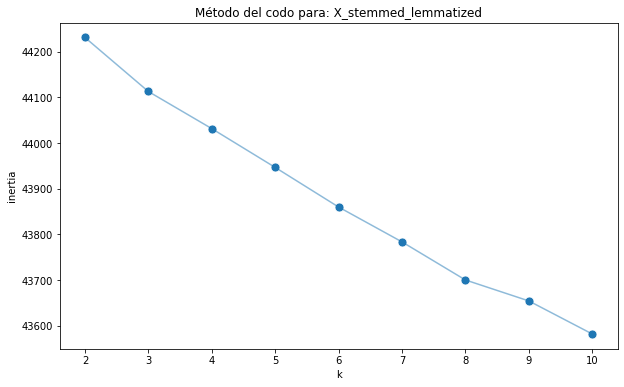

In [ ]:
%%time
inertias_X_stemmed_lemmatized = find_best_k_kmeans(X_stemmed_lemmatized, 11, "Método del codo para: X_stemmed_lemmatized")

### Seleccion de K optimo

In [ ]:
def draw_wordcloud_for_kmeans(true_k, labels):
  taged_tweets_X_stemmed = {'cluster':labels,'tweet':data['tweet']}
  taged_tweets_X_stemmed=pd.DataFrame(taged_tweets_X_stemmed)

  for k in range(0,true_k):
      tweets = taged_tweets_X_stemmed[taged_tweets_X_stemmed.cluster==k]
      
      text = tweets['tweet'].str.cat(sep=' ')
      text = text.lower()
      text = ' '.join([word for word in text.split()])
      wordcloud = WordCloud(max_words=100, background_color="white").generate(text)
      
      print('Cluster: {}'.format(k))
      print('Tweets')
      
      # titles=wiki_cl[wiki_cl.cluster==k]['tweet']
      
      # print(titles.to_string(index=False))
      plt.rcParams["figure.figsize"] = (8,4)
      plt.figure()
      plt.imshow(wordcloud, interpolation="bilinear")
      plt.axis("off")
      plt.show()

Cluster: 0
Tweets


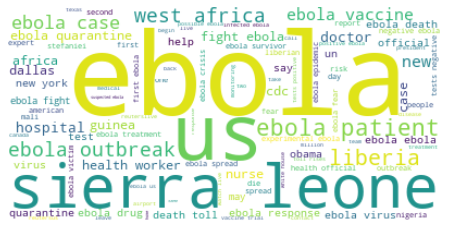

Cluster: 1
Tweets


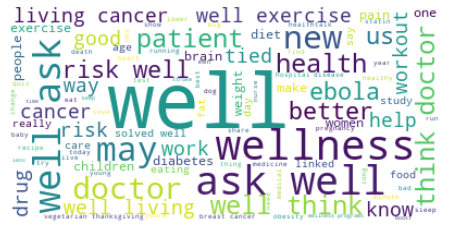

Cluster: 2
Tweets


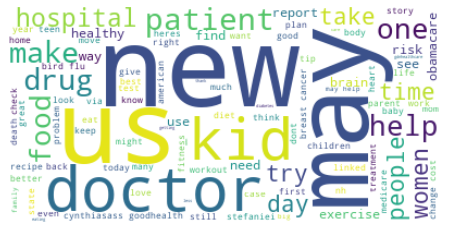

Cluster: 3
Tweets


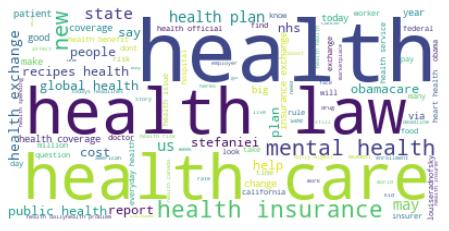

Cluster: 4
Tweets


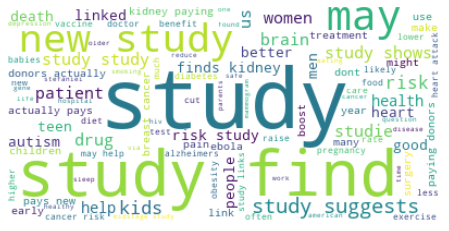

Cluster: 5
Tweets


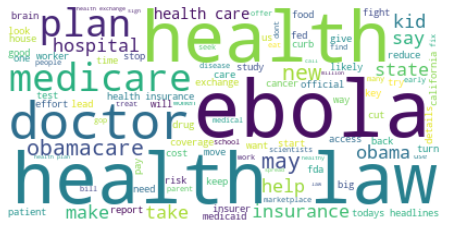

Cluster: 6
Tweets


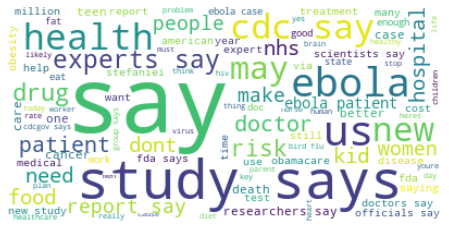

In [ ]:
# Para X_stemmed
true_k = 7
model_kmeans_X_stemmed = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10, random_state=42)
model_kmeans_X_stemmed.fit(X_stemmed)
draw_wordcloud_for_kmeans(true_k, model_kmeans_X_stemmed.labels_)

Cluster: 0
Tweets


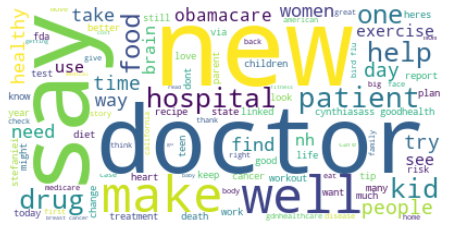

Cluster: 1
Tweets


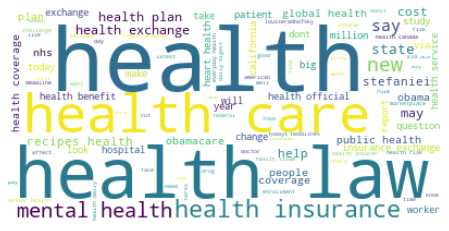

Cluster: 2
Tweets


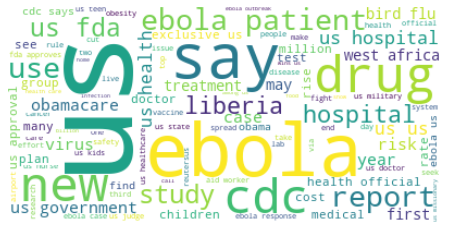

Cluster: 3
Tweets


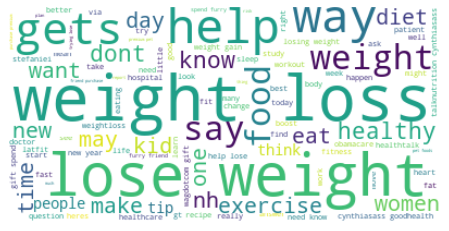

Cluster: 4
Tweets


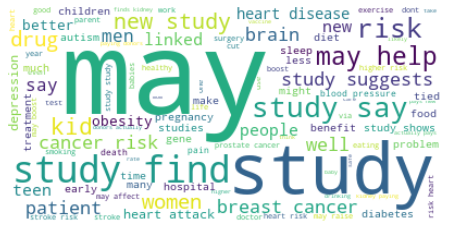

Cluster: 5
Tweets


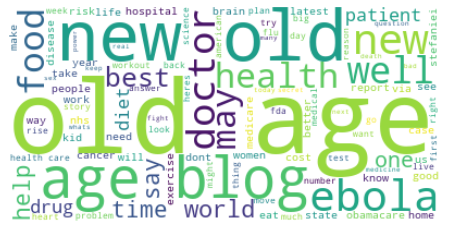

Cluster: 6
Tweets


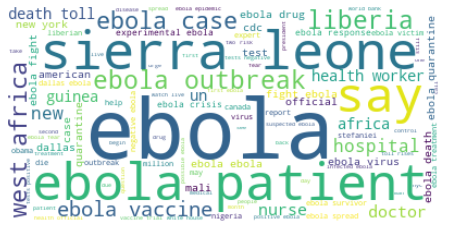

In [ ]:
# Para X_lemmatized
true_k = 7
model_kmeans_X_lemmatized = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10, random_state=42)
model_kmeans_X_lemmatized.fit(X_lemmatized)

draw_wordcloud_for_kmeans(true_k, model_kmeans_X_lemmatized.labels_)

In [ ]:
data_with_kmeans_cluster = data.copy()
data_with_kmeans_cluster['cluster'] = model_kmeans_X_lemmatized.labels_

In [ ]:
data_with_kmeans_cluster.to_csv('data_with_kmeans_cluster.csv', encoding='utf-8',sep='|',index=False)

In [ ]:
# Save
data_to_save = model_kmeans_X_lemmatized
pickle.dump(data_to_save, open( "save_kmeans_model.p", "wb" ))

In [ ]:
# Load
model_kmeans_X_lemmatized = pickle.load( open( "save_kmeans_model.p", "rb" ) )

Cluster: 0
Tweets


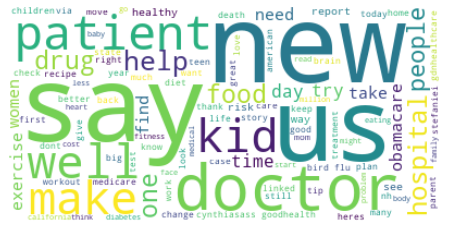

Cluster: 1
Tweets


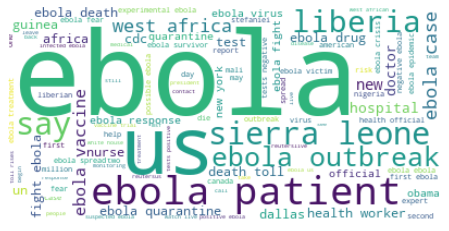

Cluster: 2
Tweets


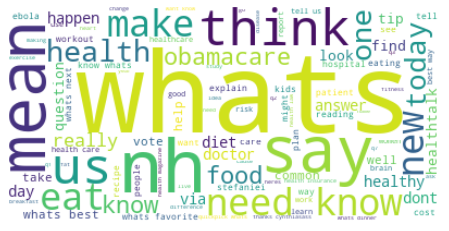

Cluster: 3
Tweets


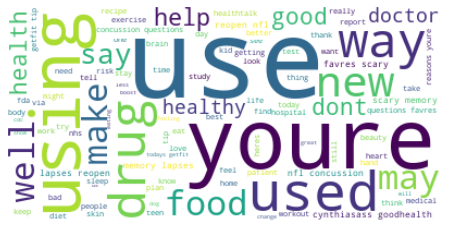

Cluster: 4
Tweets


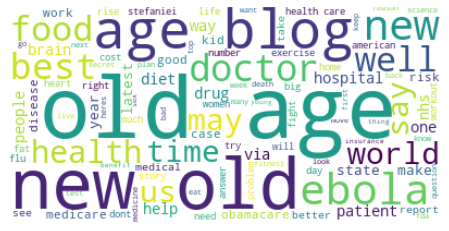

Cluster: 5
Tweets


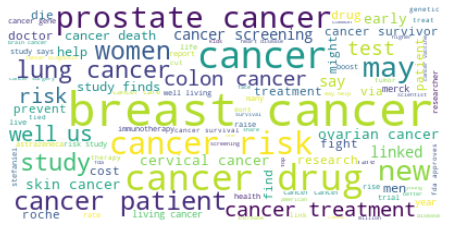

Cluster: 6
Tweets


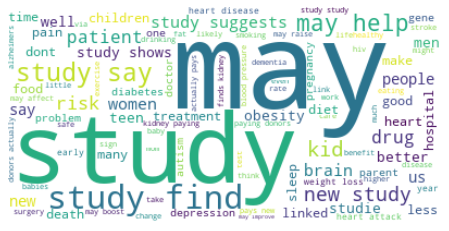

Cluster: 7
Tweets


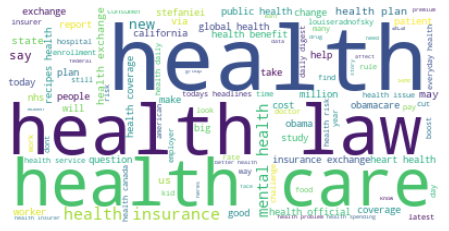

In [ ]:
# Para X_stemmed_lemmatized
true_k = 8
model_kmeans_X_stemmed_lemmatized = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10, random_state=42)
model_kmeans_X_stemmed_lemmatized.fit(X_stemmed_lemmatized)

draw_wordcloud_for_kmeans(true_k, model_kmeans_X_stemmed_lemmatized.labels_)

## Clustering Jerarquico

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

import pickle

In [ ]:
# Sample data
data_stemmed_sampled = data_stemmed.sample(frac=0.10, random_state=42)
tweets_stemmed_sampled = data_stemmed_sampled['tweet'].tolist()
X_stemmed_sampled =  vectorizer_stemmed.transform(tweets_stemmed_sampled)


In [ ]:
# Usar SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=(X_stemmed_sampled.shape[1] // 8), random_state=42)
X_stemmed_sampled_svd = svd.fit_transform(X_stemmed_sampled)

In [ ]:
# Save
data_to_save = (X_stemmed_sampled, X_stemmed_sampled_svd)
pickle.dump(data_to_save, open( "save_stemmed.p", "wb" ))

In [ ]:
# Load
(X_stemmed_sampled, X_stemmed_sampled_svd) = pickle.load( open( "save_stemmed.p", "rb" ) )

In [ ]:
# Sample data
data_lemmatized_sampled = data_lemmatized.sample(frac=0.10, random_state=42)
tweets_lemmatized_sampled = data_lemmatized_sampled['tweet'].tolist()
X_lemmatized_sampled =  vectorizer_lemmatized.transform(tweets_lemmatized_sampled)

In [ ]:
# Usar SVD
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=(X_lemmatized_sampled.shape[1] // 8), random_state=42)
X_lemmatized_sampled_svd = svd.fit_transform(X_lemmatized_sampled)

In [ ]:
# Save
data_to_save = (X_lemmatized_sampled, X_lemmatized_sampled_svd)
pickle.dump(data_to_save, open( "save_lemmatized.p", "wb" ))

In [ ]:
# Load
(X_lemmatized_sampled, X_lemmatized_sampled_svd) = pickle.load( open( "save_lemmatized.p", "rb" ) )

In [ ]:
# Sample data
data_stemmed_lemmatized_sampled = data_stemmed_lemmatized.sample(frac=0.10, random_state=42)
tweets_stemmed_lemmatized_sampled = data_stemmed_lemmatized_sampled['tweet'].tolist()
X_stemmed_lemmatized_sampled =  vectorizer_stemmed_lemmatized.transform(tweets_stemmed_lemmatized_sampled)


In [ ]:
# Usar SVD
svd = TruncatedSVD(n_components=(X_stemmed_lemmatized_sampled.shape[1] // 8), random_state=42)
X_stemmed_lemmatized_sampled_svd = svd.fit_transform(X_stemmed_lemmatized_sampled)

In [ ]:
# Save
data_to_save = (X_stemmed_lemmatized_sampled, X_stemmed_lemmatized_sampled_svd)
pickle.dump(data_to_save, open( "save_stemmed_lemmatized.p", "wb" ))

In [ ]:
# Load
(X_stemmed_lemmatized_sampled, X_stemmed_lemmatized_sampled_svd) = pickle.load( open( "save_stemmed_lemmatized.p", "rb" ) )

CPU times: user 1min 35s, sys: 108 ms, total: 1min 35s
Wall time: 1min 36s


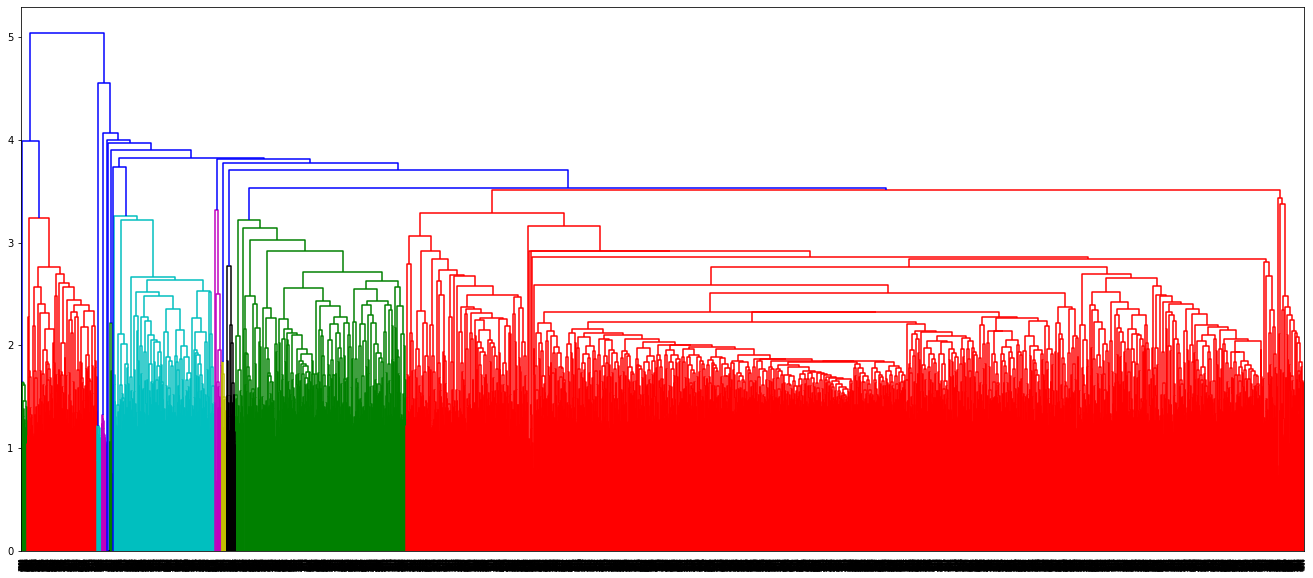

In [ ]:
%%time
plt.rcParams["figure.figsize"] = (23,10)
dendrogram_stemmed = sch.dendrogram(sch.linkage(X_stemmed_sampled_svd, method='ward'))

In [ ]:
model_agglomerative_stemmed = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
model_agglomerative_stemmed.fit(X_stemmed_sampled.toarray())
labels_agglomerative_stemmed = model_agglomerative_stemmed.labels_

In [ ]:
# Save
data_to_save = model_agglomerative_stemmed
pickle.dump(data_to_save, open( "save_model_stemmed_agglomerative.p", "wb" ))

In [ ]:
# Load
model_agglomerative_stemmed = pickle.load( open( "save_model_stemmed_agglomerative.p", "rb" ) )

CPU times: user 1min 41s, sys: 67.3 ms, total: 1min 41s
Wall time: 1min 41s


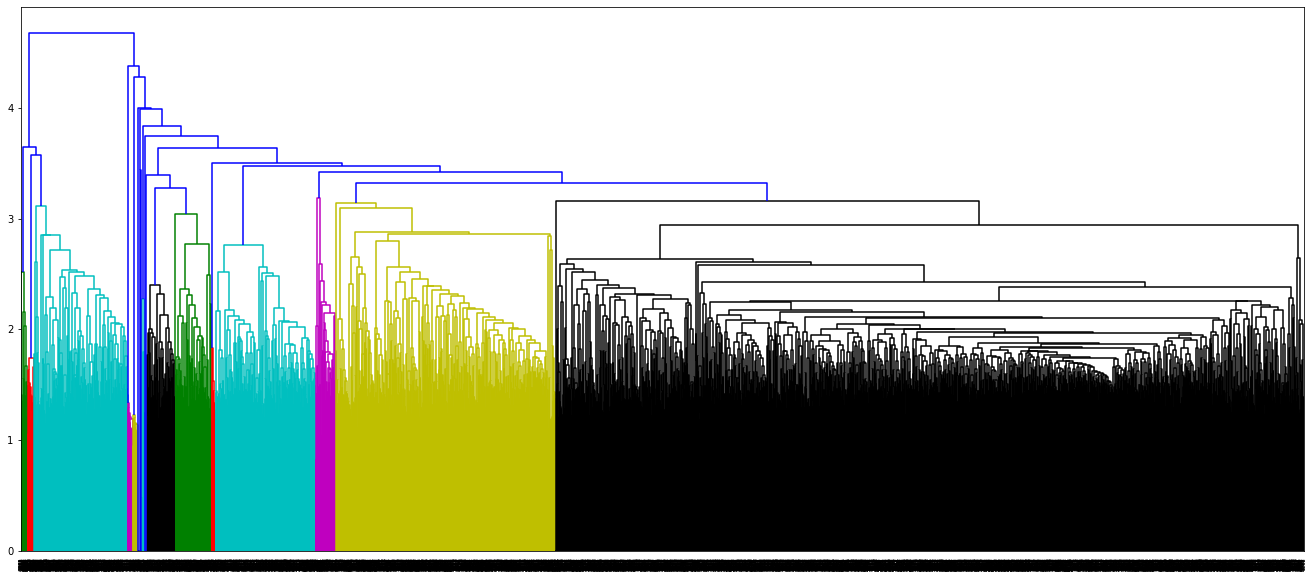

In [ ]:
%%time
dendrogram_lemmatized = sch.dendrogram(sch.linkage(X_lemmatized_sampled_svd, method='ward'))

In [ ]:
X_lemmatized_sampled

<6412x34453 sparse matrix of type '<class 'numpy.float64'>'
	with 54758 stored elements in Compressed Sparse Row format>

In [ ]:
model_agglomerative_lemmatized = AgglomerativeClustering(n_clusters=9, affinity='euclidean', linkage='ward')
model_agglomerative_lemmatized.fit(X_lemmatized_sampled.toarray())
labels_agglomerative_lemmatized = model_agglomerative_lemmatized.labels_

In [ ]:
# Save
data_to_save = model_agglomerative_lemmatized
pickle.dump(data_to_save, open( "save_model_lemmatized_agglomerative.p", "wb" ))

In [ ]:
# Load
model_agglomerative_lemmatized = pickle.load( open( "save_model_lemmatized_agglomerative.p", "rb" ) )

CPU times: user 1min 33s, sys: 355 ms, total: 1min 33s
Wall time: 1min 33s


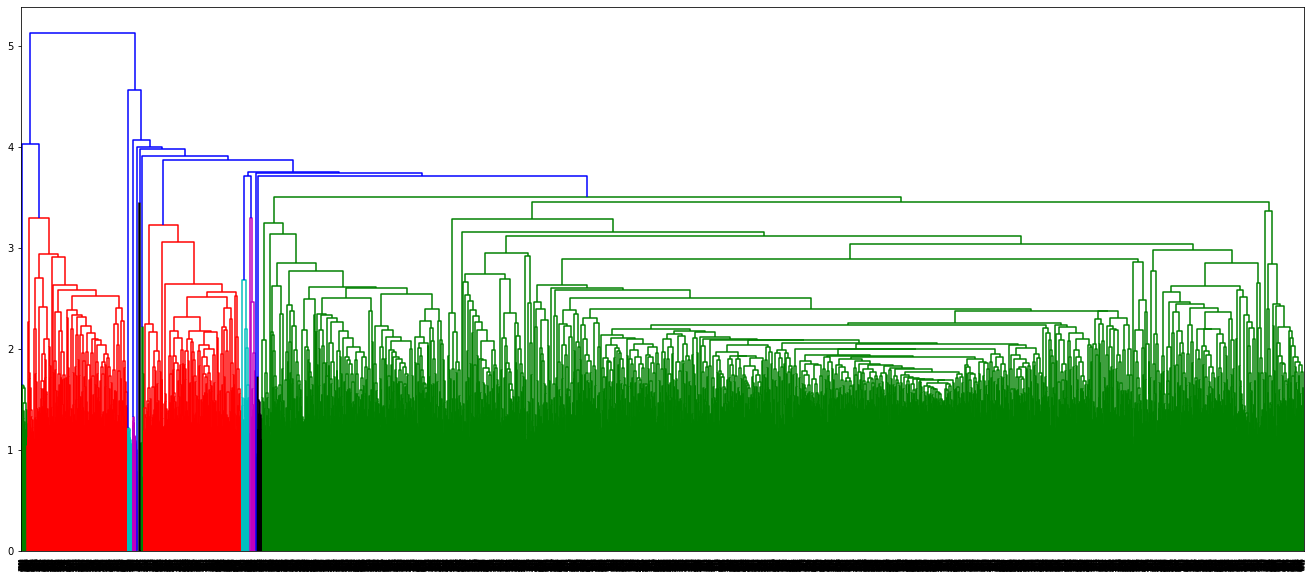

In [ ]:
%%time
dendrogram_stemmed = sch.dendrogram(sch.linkage(X_stemmed_lemmatized_sampled_svd, method='ward'))

In [ ]:
model_agglomerative_stemmed_lemmatized = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
model_agglomerative_stemmed_lemmatized.fit(X_stemmed_lemmatized_sampled.toarray())
labels_agglomerative_stemmed_lemmatized = model_agglomerative_stemmed_lemmatized.labels_

In [ ]:
# Save
data_to_save = model_agglomerative_stemmed_lemmatized
pickle.dump(data_to_save, open( "save_model_stemmed_lemmatized_agglomerative.p", "wb" ))

In [ ]:
# Load
model_agglomerative_stemmed_lemmatized = pickle.load( open( "save_model_stemmed_lemmatized_agglomerative.p", "rb" ) )

#### Analisis


In [ ]:
def draw_wordcloud_for_agglomerative(true_k, labels, data):
  taged_tweets_X_stemmed = {'cluster':labels,'tweet':data['tweet']}
  taged_tweets_X_stemmed = pd.DataFrame(taged_tweets_X_stemmed)

  for k in range(0,true_k):
      tweets = taged_tweets_X_stemmed[taged_tweets_X_stemmed.cluster==k]
      
      text = tweets['tweet'].str.cat(sep=' ')
      text = text.lower()
      text = ' '.join([word for word in text.split()])
      wordcloud = WordCloud(max_words=100, background_color="white").generate(text)
      
      print('Cluster: {}'.format(k))
      print('Tweets')
      
      # titles=wiki_cl[wiki_cl.cluster==k]['tweet']
      
      # print(titles.to_string(index=False))
      plt.rcParams["figure.figsize"] = (8,4)
      plt.figure()
      plt.imshow(wordcloud, interpolation="bilinear")
      plt.axis("off")
      plt.show()

In [ ]:
X_stemmed_lemmatized_sampled

<6412x26040 sparse matrix of type '<class 'numpy.float64'>'
	with 54659 stored elements in Compressed Sparse Row format>

stemmed

Cluster: 0
Tweets


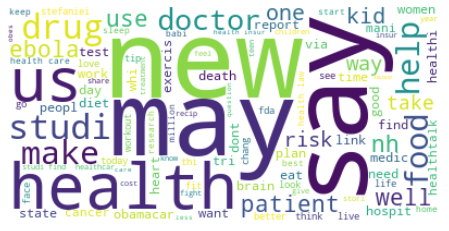

Cluster: 1
Tweets


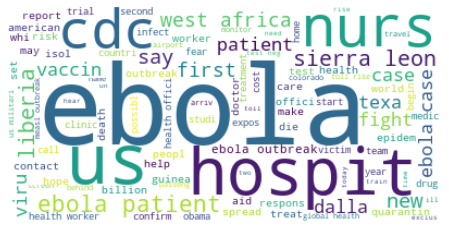

Cluster: 2
Tweets


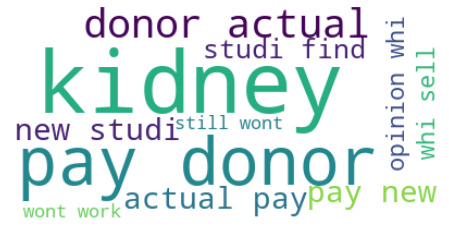

Cluster: 3
Tweets


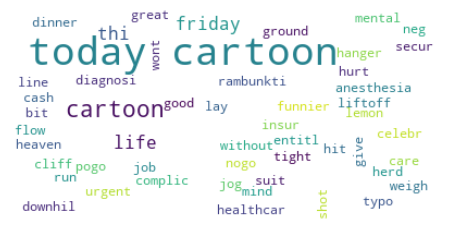

Cluster: 4
Tweets


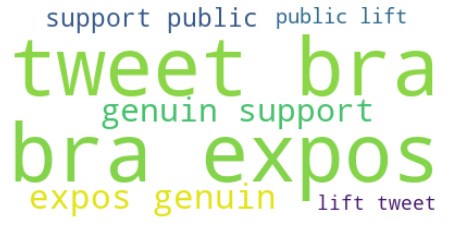

lemmatized

Cluster: 0
Tweets


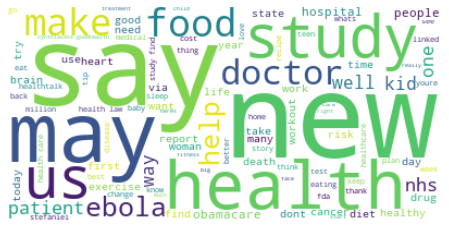

Cluster: 1
Tweets


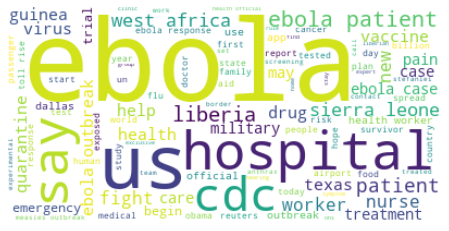

Cluster: 2
Tweets


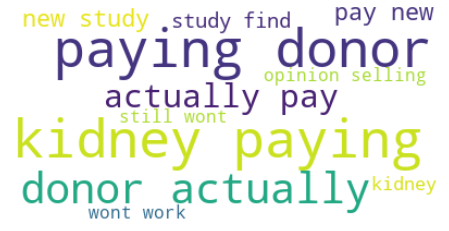

Cluster: 3
Tweets


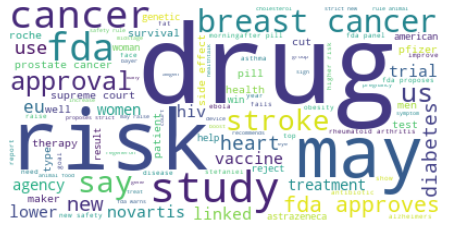

Cluster: 4
Tweets


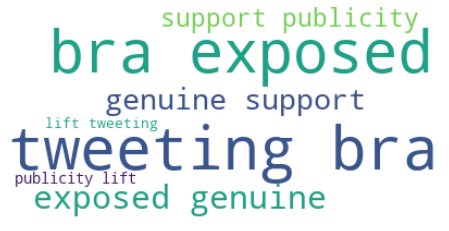

stemmed_lemmatized

Cluster: 0
Tweets


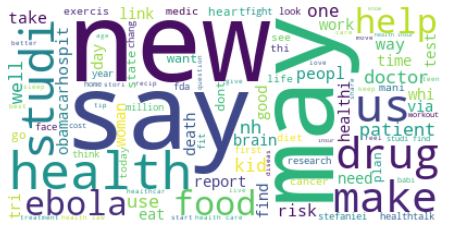

Cluster: 1
Tweets


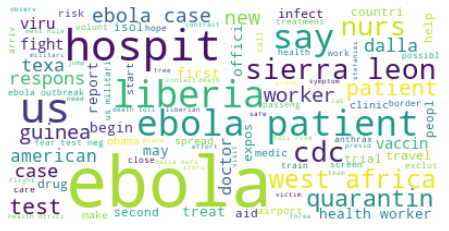

Cluster: 2
Tweets


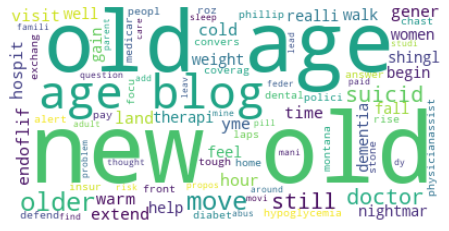

Cluster: 3
Tweets


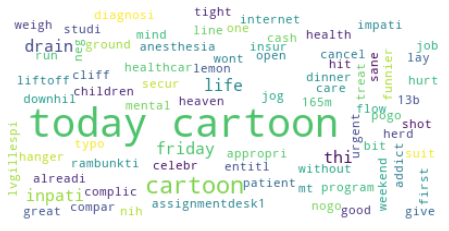

Cluster: 4
Tweets


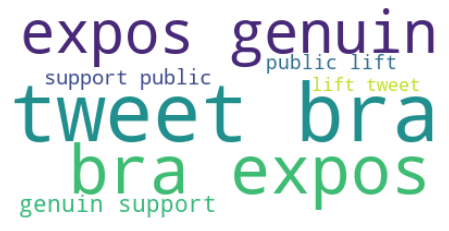

In [ ]:
# stemmed
print('stemmed\n')
draw_wordcloud_for_agglomerative(5, list(labels_agglomerative_stemmed), data_stemmed_sampled)
# lemmatized
print('lemmatized\n')
draw_wordcloud_for_agglomerative(5, list(labels_agglomerative_lemmatized), data_lemmatized_sampled)
# stemmed_lemmatized
print('stemmed_lemmatized\n')
draw_wordcloud_for_agglomerative(5, list(labels_agglomerative_stemmed_lemmatized), data_stemmed_lemmatized_sampled)

## Spectral

In [ ]:
from scipy.sparse import csgraph
from numpy import linalg as LA
from scipy.spatial.distance import pdist, squareform

def getAffinityMatrix(coordinates, k = 7):
    """
    Calculate affinity matrix based on input coordinates matrix and the numeber
    of nearest neighbours.
    
    Apply local scaling based on the k nearest neighbour
        References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    """
    # calculate euclidian distance matrix
    dists = squareform(pdist(coordinates)) 
    
    # for each row, sort the distances ascendingly and take the index of the 
    #k-th position (nearest neighbour)
    knn_distances = np.sort(dists, axis=0)[k]
    knn_distances = knn_distances[np.newaxis].T
    
    # calculate sigma_i * sigma_j
    local_scale = knn_distances.dot(knn_distances.T)

    affinity_matrix = dists * dists
    affinity_matrix = -affinity_matrix / local_scale
    # divide square distance matrix by local scale
    affinity_matrix[np.where(np.isnan(affinity_matrix))] = 0.0
    # apply exponential
    affinity_matrix = np.exp(affinity_matrix)
    np.fill_diagonal(affinity_matrix, 0)
    return affinity_matrix

def eigenDecomposition(A, plot = True, topK = 5):
    """
    :param A: Affinity matrix
    :param plot: plots the sorted eigen values for visual inspection
    :return A tuple containing:
    - the optimal number of clusters by eigengap heuristic
    - all eigen values
    - all eigen vectors
    
    This method performs the eigen decomposition on a given affinity matrix,
    following the steps recommended in the paper:
    1. Construct the normalized affinity matrix: L = D−1/2ADˆ −1/2.
    2. Find the eigenvalues and their associated eigen vectors
    3. Identify the maximum gap which corresponds to the number of clusters
    by eigengap heuristic
    
    References:
    https://papers.nips.cc/paper/2619-self-tuning-spectral-clustering.pdf
    http://www.kyb.mpg.de/fileadmin/user_upload/files/publications/attachments/Luxburg07_tutorial_4488%5b0%5d.pdf
    """
    L = csgraph.laplacian(A, normed=True)
    n_components = A.shape[0]
    
    # LM parameter : Eigenvalues with largest magnitude (eigs, eigsh), that is, largest eigenvalues in 
    # the euclidean norm of complex numbers.
    eigenvalues, eigenvectors = LA.eig(L)
    
    if plot:
       plt.title('Largest eigen values of input matrix')
       plt.scatter(np.arange(len(eigenvalues)), eigenvalues)
       plt.grid()
        
    # Identify the optimal number of clusters as the index corresponding
    # to the larger gap between eigen values
    index_largest_gap = np.argsort(np.diff(eigenvalues))[::-1][:topK]
    nb_clusters = index_largest_gap + 1
        
    return nb_clusters, eigenvalues, eigenvectors

In [ ]:
%%time
affinity_matrix = getAffinityMatrix(X_stemmed_sampled[:1000].toarray(), k = 10, )
k, _,  _ = eigenDecomposition(affinity_matrix, plot=False)
print(f'Optimal number of clusters for X_stemmed: {k}')

Optimal number of clusters for X_stemmed: [ 1 27 33 67 75]
CPU times: user 21.2 s, sys: 1.11 s, total: 22.3 s
Wall time: 20.7 s


Optimal number of clusters for X_lemmatized: [  1 103 118 120 124]
CPU times: user 1min 58s, sys: 4.17 s, total: 2min 2s
Wall time: 1min 52s


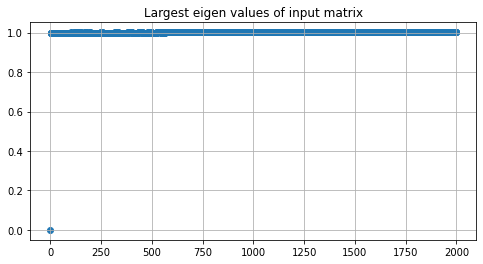

In [ ]:
%%time
affinity_matrix = getAffinityMatrix(X_lemmatized_sampled[:2000].toarray(), k = 10)
k, _,  _ = eigenDecomposition(affinity_matrix)
print(f'Optimal number of clusters for X_lemmatized: {k}')

Optimal number of clusters for X_stemmed_lemmatized: [ 1 38 50 54 61]
CPU times: user 22 s, sys: 991 ms, total: 23 s
Wall time: 21.3 s


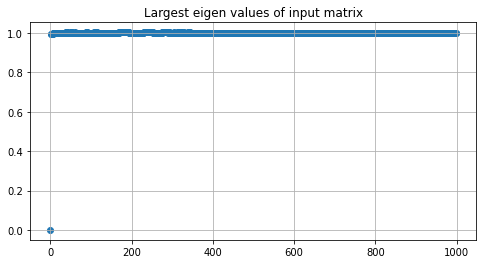

In [ ]:
%%time
affinity_matrix = getAffinityMatrix(X_stemmed_lemmatized_sampled[:1000].toarray(), k = 10)
k, _,  _ = eigenDecomposition(affinity_matrix)
print(f'Optimal number of clusters for X_stemmed_lemmatized: {k}')